# Graph measures

This script showcases how to use some graph measures included in the comet toolbox.


In [1]:
import bct
import numpy as np
from nilearn import datasets
from matplotlib import pyplot as plt
from comet import graph
import time

# Get preprocessed time series data from the ABIDE dataset
subjects = [50008, 50010, 50012, 50014]
data = datasets.fetch_abide_pcp(SUB_ID=subjects, pipeline='cpac', band_pass_filtering=True, derivatives="rois_dosenbach160")

[fetch_abide_pcp] Dataset found in /home/mibur/nilearn_data/ABIDE_pcp

Calculate and plot static functional connectivity:

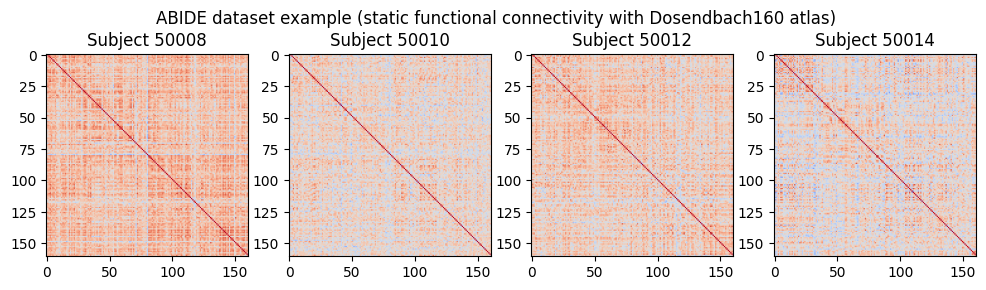

In [2]:
fig, ax = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('ABIDE dataset example (static functional connectivity with Dosendbach160 atlas)')

fc = []
for sub in range(len(subjects)):
    ts = data.rois_dosenbach160[sub]
    corr = np.corrcoef(ts.T)
    fc.append(corr)
    ax[sub].imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    ax[sub].set_title('Subject %d' % subjects[sub])

Graph construction and plotting of the resulting adjacency matrices:

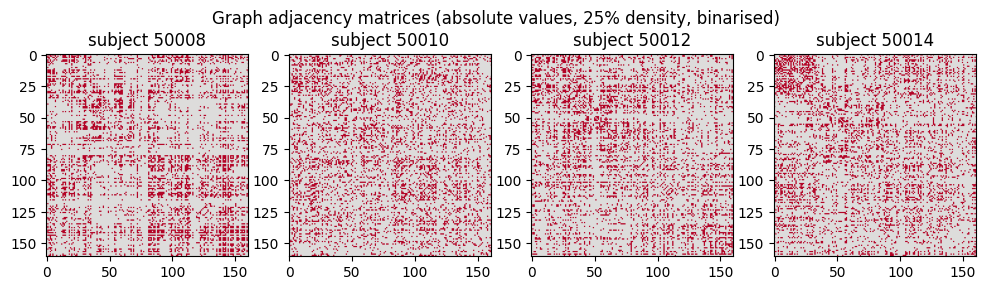

In [3]:
fig, ax = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Graph adjacency matrices (absolute values, 25% density, binarised)')

G = []
for i, sub in enumerate(subjects):
    g = graph.handle_negative_weights(fc[i], type="absolute")
    g = graph.threshold(g, type="density", density=0.2)
    g = graph.binarise(g)
    ax[i].imshow(g, cmap='coolwarm', vmin=-1, vmax=1)
    ax[i].set_title(f"subject {sub}")
    G.append(g)

Calculate small-world sigma:

In [4]:
for i, sub in enumerate(subjects):
    swp1 = graph.small_world_propensity(G[i])[0]
    print(f"Subject {sub} small-world propensity: {swp1:.2f}")

/home/mibur/comet/src/comet/graph.py:477: UserWarning: The graph is not fully connected; infinite path lengths were set to NaN.
  warnings.warn("The graph is not fully connected; infinite path lengths were set to NaN.")


Subject 50008 small-world propensity: 0.72
Subject 50010 small-world propensity: 0.52
Subject 50012 small-world propensity: 0.65
Subject 50014 small-world propensity: 0.60


Calculate local efficiency:

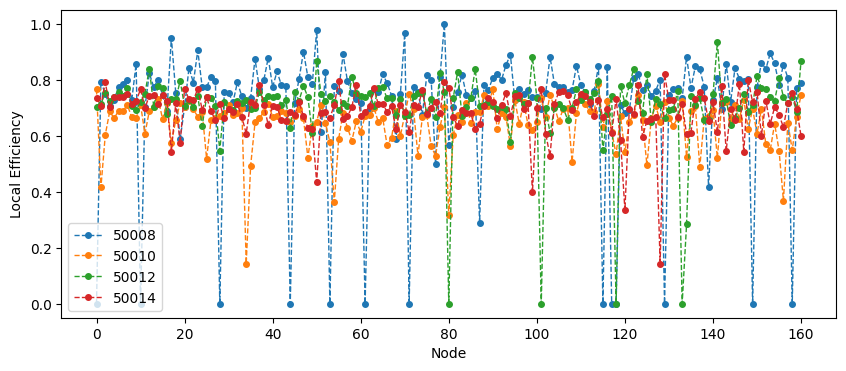

In [5]:
eff = []
for i, sub in enumerate(subjects):
    eff.append(graph.efficiency(G[i], local=True))

eff = np.asarray(eff).T

plt.figure(figsize=(10,4))
plt.plot(eff, label=subjects, marker='o', markersize=4, linestyle='--', linewidth=1)
plt.xlabel('Node')
plt.ylabel('Local Efficiency')
plt.legend();

We can benchmark the performance of the local efficiency algorithm with the BCT implementation. We can see that the Comet method is much faster, especially for large networks.

The following code block will run for 10-15 minutes, so it might be preferable to enjoy the figure instead of running it again :)

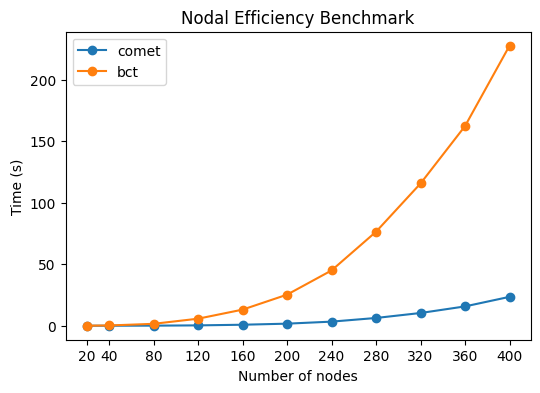

In [6]:
# Random graph with 400 nodes and 50% density
W = np.random.rand(400,400)
W = graph.symmetrise(W)
W = graph.threshold(W, type="density", density=0.5)

# Init methods at least once to avoid first-time overhead
init_comet = graph.efficiency(W[:10,:10], local=True)
init_bct = bct.efficiency_wei(W[:10,:10])

# Run efficiency computation with increasing number of nodes
eff_comet = []
eff_bct = []
nodes = [20,40,80,120,160,200,240,280,320,360,400] # this will probably take more than 10 minutes

for i in nodes:
    start = time.time()
    eff = graph.efficiency(W[:i,:i], local=True)
    eff_comet.append(time.time() - start)

    start = time.time()
    eff = bct.efficiency_wei(W[:i,:i], local=True)
    eff_bct.append(time.time() - start)

# Plot the results
plt.figure(figsize=(6,4))
plt.title('Nodal Efficiency Benchmark')
plt.plot(nodes, eff_comet, label="comet", marker='o')
plt.plot(nodes, eff_bct, label="bct", marker='o')
plt.xlabel('Number of nodes')
plt.xticks(nodes)
plt.ylabel('Time (s)')
plt.legend();

Matching index calculations are also significantly faster:

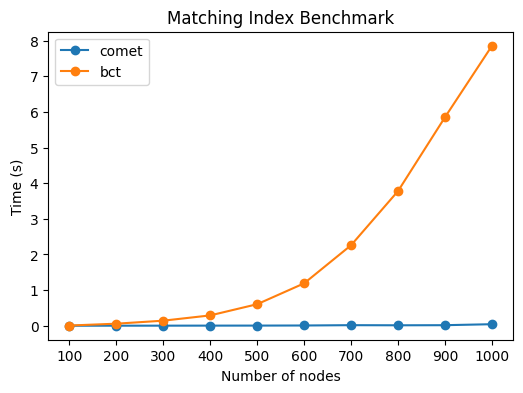

In [7]:
# Random graph with 400 nodes and 50% density
W = np.random.rand(1000,1000)
W = graph.symmetrise(W)
W = graph.threshold(W, type="density", density=0.5)

# Init methods at least once to avoid first-time overhead
init_comet = graph.matching_ind_und(W[:10,:10])
init_bct = bct.matching_ind_und(W[:10,:10])

# Run efficiency computation with increasing number of nodes
eff_comet = []
eff_bct = []
nodes = [100,200,300,400,500,600,700,800,900,1000]

for i in nodes:
    start = time.time()
    eff = graph.matching_ind_und(W[:i,:i])
    eff_comet.append(time.time() - start)

    start = time.time()
    eff = bct.matching_ind_und(W[:i,:i])
    eff_bct.append(time.time() - start)

# Plot the results
plt.figure(figsize=(6,4))
plt.title('Matching Index Benchmark')
plt.plot(nodes, eff_comet, label="comet", marker='o')
plt.plot(nodes, eff_bct, label="bct", marker='o')
plt.xlabel('Number of nodes')
plt.xticks(nodes)
plt.ylabel('Time (s)')
plt.legend();